### Mackey-Glass series generation
$$
    \frac{dx(t)}{dt} = -ax(t) + \frac{bx(t-\tau)}{1+x(t-\tau)^{10}}
$$

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

N = 5000
tt = 6  # Sampling period
dt = 0.01  # Integration step
a = 0.1
b = 0.2
x0 = 0.9
tau = 30  # Chaotic: tau=30, Periodic: tau=17

N_full = int(N*tt/dt)
tau_full = int(tau/dt)
xmg = x0*np.ones(shape=(N_full+1, ))
# Runge-Kutta integration
for n in range(tau_full, N_full):
    xx = xmg[n]
    xd = xmg[n-tau_full]
    bxd = b*xd/(1.0 + xd**10.0)
    xk1 = dt*(-a*xx + bxd)
    xk2 = dt*(-a*(xx+xk1/2) + bxd)
    xk3 = dt*(-a*(xx+xk2/2) + bxd)
    xk4 = dt*(-a*(xx+xk3) + bxd)
    xmg[n+1] = xx + xk1/6 + xk2/3 +xk3/3 +xk4/6;

x = xmg[::int(tt/dt)]

### Training and test subset generation

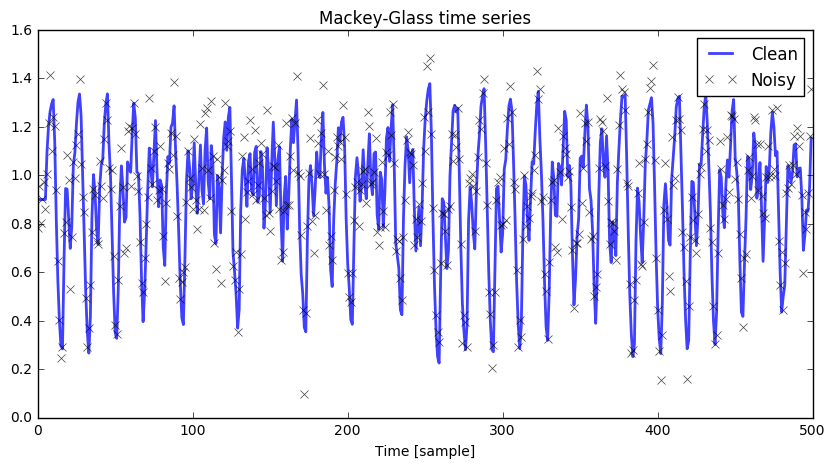

In [6]:
x_noisy = x + 0.1*np.random.randn(len(x))

plt.close()
fig = plt.figure(figsize=(10, 5), dpi=150)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x[0:500], 'b-', linewidth=2, alpha=0.75, label='Clean')
ax.plot(x_noisy[0:500], 'kx', alpha=0.75, label='Noisy')
ax.legend()
plt.xlabel('Time [sample]')
plt.title('Mackey-Glass time series')

embed = 10  # embedding dimension
step = 1  # prediction step
Ntrain = 1000
Ntest = 100
x_train = np.zeros(shape=(Ntrain, embed))
for i in range(0, Ntrain):
    x_train[i, :] = x_noisy[i:i+embed]

x_test = np.zeros(shape=(Ntest, embed))
for i in range(0,Ntest):
    x_test[i, :] = x_noisy[i+Ntrain:i+embed+Ntrain]

y_train = x_noisy[embed+step:embed+step+Ntrain]
y_test = x_noisy[embed+step+Ntrain:embed+step+Ntest+Ntrain]
y_test_clean = x[embed+step+Ntrain:embed+step+Ntest+Ntrain]

## Kernel Least Mean Squares

#### Learning mode:
Regression: No output transformtion. 
Classification: Sigmoid transformation on the output

#### Gaussian kernel
$$
\kappa(x, y) = \exp(-\gamma \| x - y \|^2)
$$

#### Growing criterion: Novelty
For a new sample $u(i+1)$ compute
$$
d_1 = \min_{c_j \in C(i)} \| u(i+1) -c_j \|
$$
If $d_1 < \delta_1$, then $u(i+1)$ does not enter the dictionary, else compute the prediction error $e(i+1)$. 

If $ e(i+1) > \delta_2 $, then $u(i+1)$ enters the dictionary.

growing_params = [$\delta_1$, $\delta_2$]



In [4]:
# From https://github.com/EderSantana/adaptive_kernel_methods

from kernel_lms import KernelLMS
import warnings
warnings.filterwarnings('ignore')

klms = KernelLMS(learning_mode="regression", learning_rate=1.0,  
                 kernel="rbf", gamma=1.0, growing_criterion="novelty", 
                 growing_param=[0.1, 0.1], loss_function="least_squares")

p_train = klms.fit(x_train, y_train)

Test set MSE: 0.05636


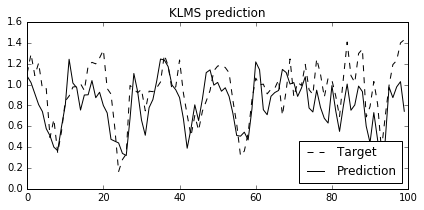

In [14]:
fig = plt.figure(figsize=(6, 3), dpi=150)
ax = fig.add_subplot(1, 1, 1)
p_test = klms.transform(x_test)
ax.plot(y_test, 'k--', label='Target')
#ax.plot(y_test_clean, 'k-', label='Clean Target')
ax.plot(p_test, 'k-', label='Prediction')
#plt.xlabel('Time [sample]')
#plt.title('Test set prediction')
plt.title('KLMS prediction')
ax.legend(loc=4)
"""
ax = fig.add_subplot(1, 2, 2)
ax.plot(np.power(p_test - y_test, 2.0), 'b-', label='Prediction')
plt.xlabel('Time [sample]')
plt.title('Test set square error')
print("Centers retained in the dictionary: %d" % klms.centers_.shape[0])
"""
print("Test set MSE: %0.5f" % np.average(np.power(p_test - y_test, 2.0)))

plt.tight_layout()
